In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# load data
traffic = pd.read_csv('traffic_volume.csv')
traffic.head()

,temp,clouds_all,hour,is_weekend,traffic_volume
0,288.28,40,9,0,5545
1,289.36,75,10,0,4516
2,289.58,90,11,0,4767
3,290.13,90,12,0,5026
4,291.14,75,13,0,4918


In [4]:
# split train test
from sklearn.model_selection import train_test_split

feature = traffic.drop(columns='traffic_volume')
target = traffic[['traffic_volume']]

feature_traffic_pretrain, feature_traffic_test, target_traffic_pretrain, target_traffic_test = train_test_split(feature, target, test_size=0.20, random_state=42)

feature_traffic_train, feature_traffic_validation, target_traffic_train, target_traffic_validation = train_test_split(feature_traffic_pretrain, target_traffic_pretrain, test_size=0.20, random_state=42)

In [5]:
# calulcate vif scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_traffic_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,temp,1.050419
2,clouds_all,1.037852
3,hour,1.013055
4,is_weekend,1.000949


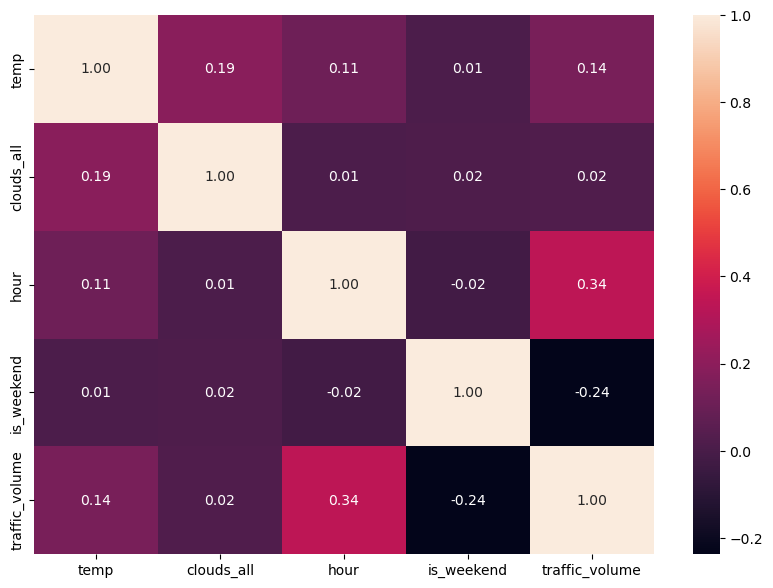

In [6]:
# heatmap correlation
traffic_train = pd.concat([feature_traffic_train, target_traffic_train], axis=1)
corr = traffic_train.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

In [7]:
from sklearn.linear_model import Lasso

# train the model
X_traffic_train = feature_traffic_train.to_numpy()
y_traffic_train = target_traffic_train.to_numpy()
y_traffic_train = y_traffic_train.reshape(len(y_traffic_train),)

# define the model
lasso_reg_pointzeroone = Lasso(alpha=0.01, random_state=42)
lasso_reg_pointone = Lasso(alpha=0.1, random_state=42)
lasso_reg_one = Lasso(alpha=1, random_state=42)
lasso_reg_ten = Lasso(alpha=10, random_state=42)

# fit the model (training)
lasso_reg_pointzeroone.fit(X_traffic_train, y_traffic_train)
lasso_reg_pointone.fit(X_traffic_train, y_traffic_train)
lasso_reg_one.fit(X_traffic_train, y_traffic_train)
lasso_reg_ten.fit(X_traffic_train, y_traffic_train)

Lasso(alpha=10, random_state=42)

In [8]:
from sklearn.metrics import mean_squared_error

X_traffic_validation = feature_traffic_validation.to_numpy()
y_traffic_validation = target_traffic_validation.to_numpy()
y_traffic_validation = y_traffic_validation.reshape(len(y_traffic_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [lasso_reg_pointzeroone,
          lasso_reg_pointone,
          lasso_reg_one,
          lasso_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_traffic_validation)
    rmse = np.sqrt(mean_squared_error(y_traffic_validation,y_predict_validation))
    print(f'RMSE of Lasso regression model with alpha = {alpha} is {rmse}')

RMSE of Lasso regression model with alpha = 0.01 is 1758.7557046935883
RMSE of Lasso regression model with alpha = 0.1 is 1758.74786966802
RMSE of Lasso regression model with alpha = 1.0 is 1758.669967940547
RMSE of Lasso regression model with alpha = 10 is 1758.0103093447253


In [9]:
lasso_best = lasso_reg_ten

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_traffic_train.columns.tolist(),
    'coefficient':[lasso_best.intercept_] + list(lasso_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,-4365.600873
1,temp,25.016157
2,clouds_all,0.003057
3,hour,93.107203
4,is_weekend,-957.562828


In [10]:
from sklearn.metrics import r2_score

y_predict_train = lasso_best.predict(X_traffic_train)

print('R-squared for training data is {}'.format(r2_score(y_traffic_train, y_predict_train)))

R-squared for training data is 0.17925637278788886


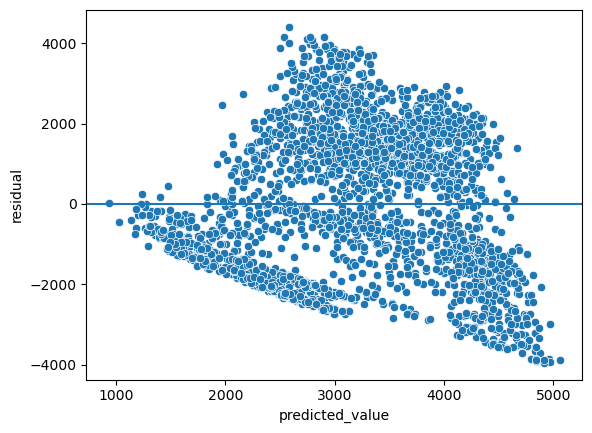

In [11]:
# calculate residuals
residual = y_traffic_train - y_predict_train

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

Cek asumsi:
1. Linear relationship: Rather OK. 
2. Variance konstan: NO.
3. Residual independent: NO.

In [12]:
# prepare prediction result on training data
y_predict_train = lasso_best.predict(X_traffic_train)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_traffic_train, y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_traffic_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_traffic_train, y_predict_train)))

RMSE for training data is 1805.286522023116
MAE for training data is 1591.520712197725
MAPE for training data is 1.3231338056293218


In [13]:
# prepare prediction result on test data
X_traffic_test = feature_traffic_test.to_numpy()
y_predict_test = lasso_best.predict(X_traffic_test)

# ground truth target
y_traffic_test = target_traffic_test.to_numpy()
y_traffic_test = y_traffic_test.reshape(len(y_traffic_test),)

In [14]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_traffic_test, y_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_traffic_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_traffic_test, y_predict_test)))

RMSE for testing data is 1814.257100567723
MAE for testing data is 1612.5211560998812
MAPE for testing data is 1.4596738579160262
